In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

In [35]:
water_quality_df_1 = pd.read_csv("./data/water-quality-site1.csv")
water_quality_df_2 = pd.read_csv("./data/water-quality-site2.csv")

# Lat, Long ,Time, Date 
water_quality_columns_to_drop = ['Latitude', 'Longitude', 'Time', 'Date', 'Nitrite (mg/L)']


In [36]:
### CLEAN DATA BY FILLING EMPTY COLUMS WITH MEAN VALUE

def fill_in_empty_cells_with_average(df):
    df = df.drop(columns=water_quality_columns_to_drop)
    for col in df:    
        df[col].fillna(value=df[col].mean(), inplace=True)

fill_in_empty_cells_with_average(water_quality_df_1)
fill_in_empty_cells_with_average(water_quality_df_2)

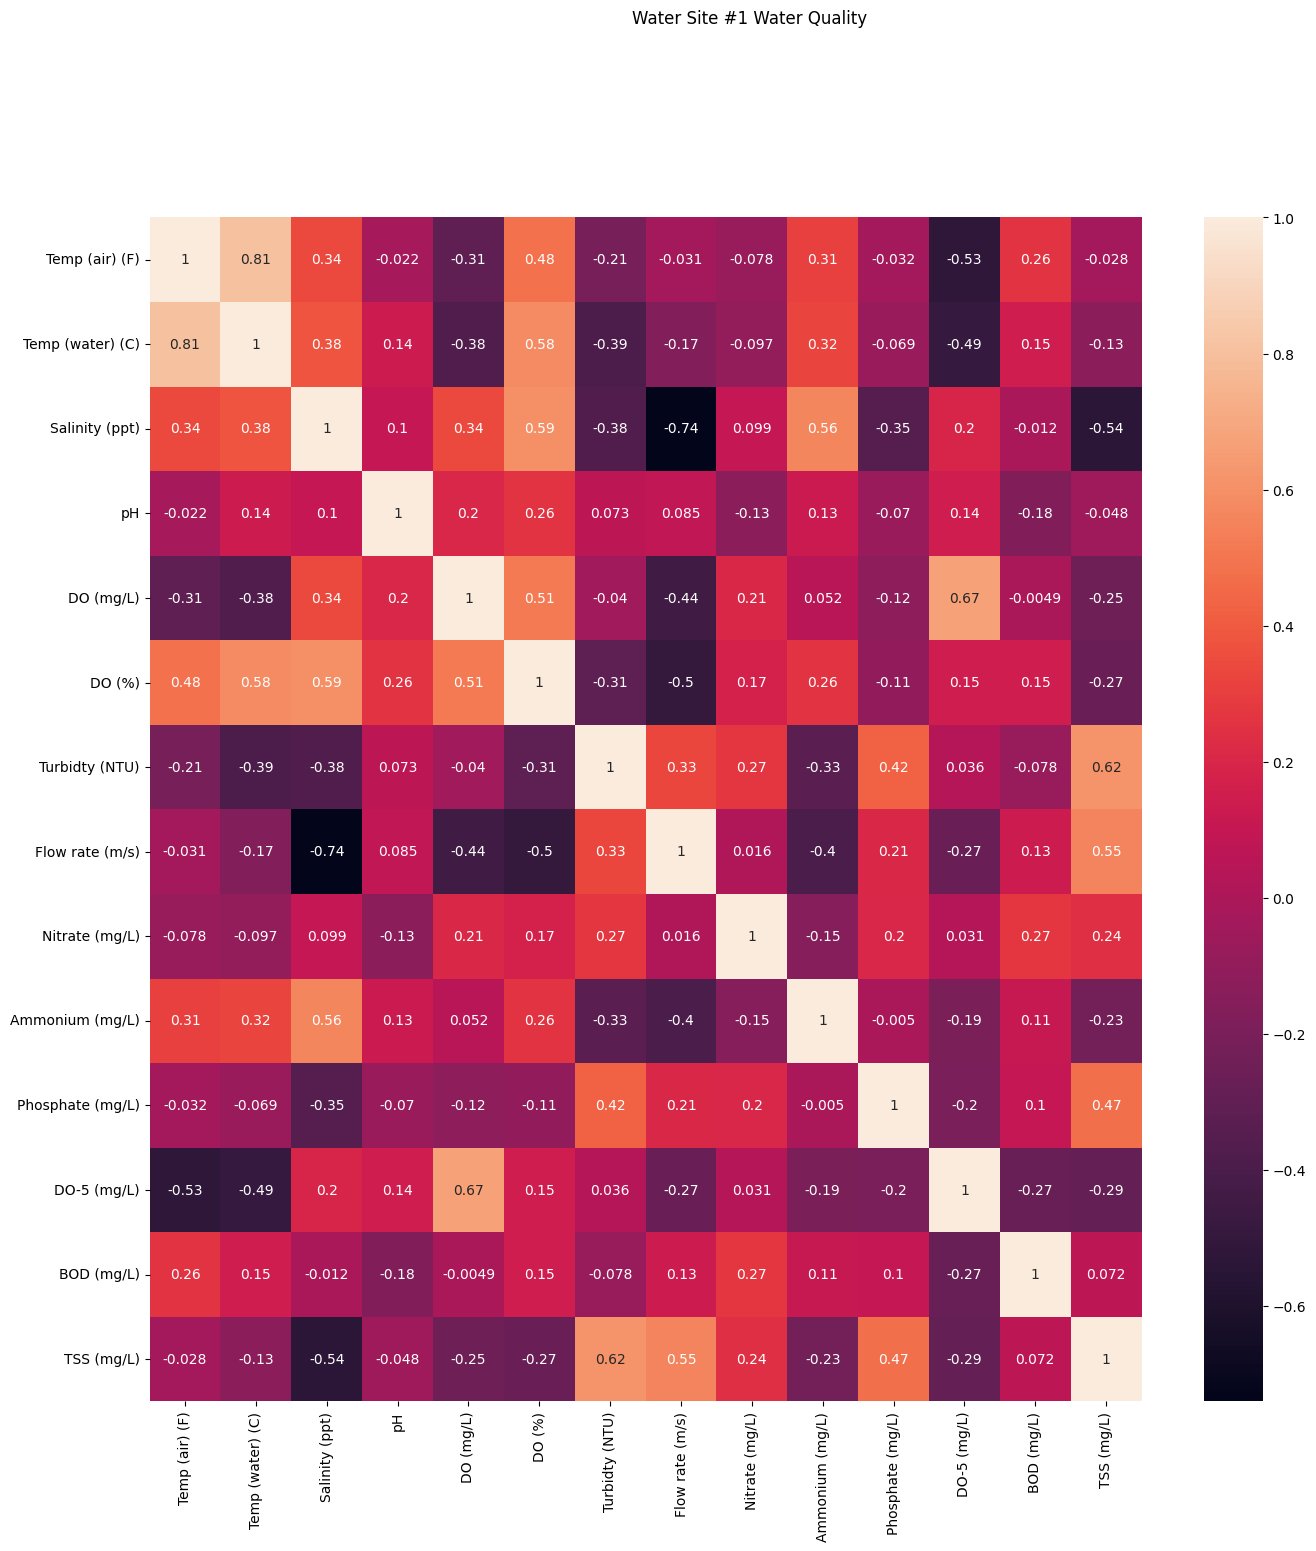

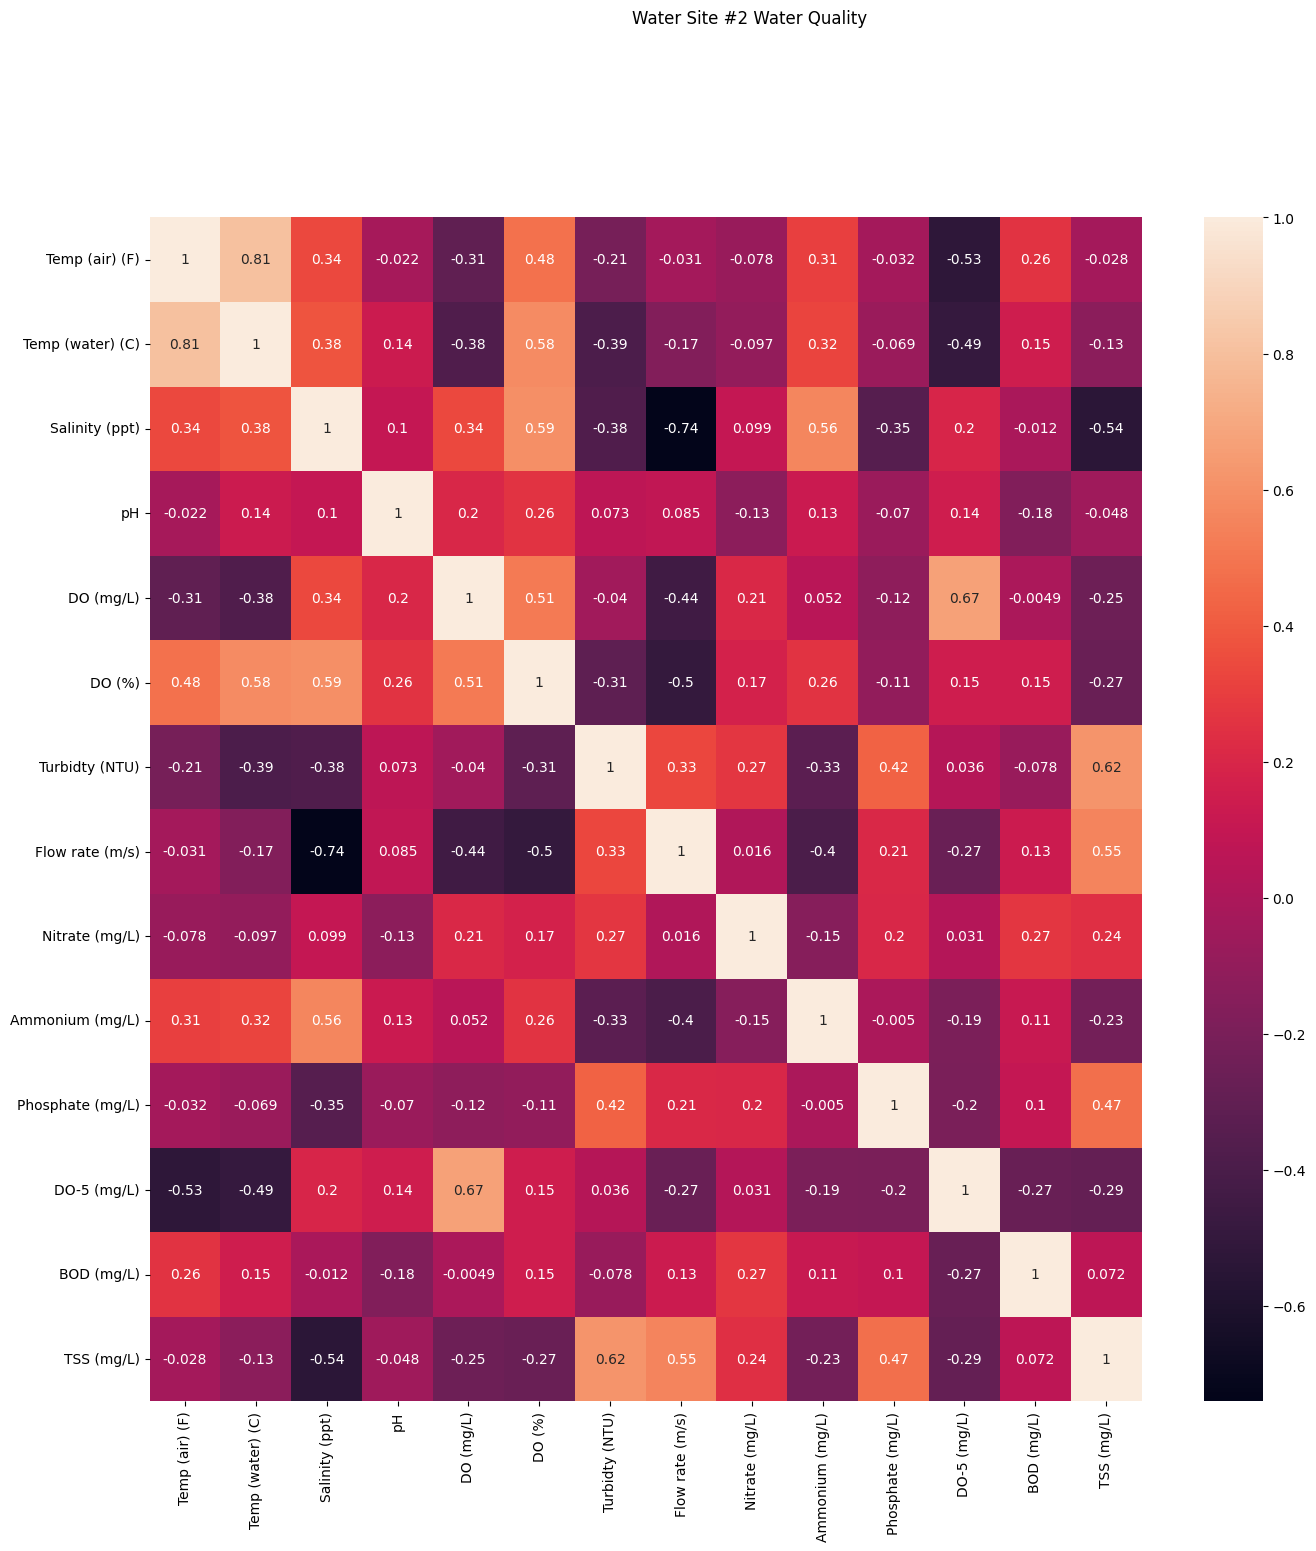

In [33]:
def make_correlation_matrix(dataframe, name, filename):
    corr_matrix = water_quality_df.corr()
    plt.subplots(figsize=(16,16))
    figure = sn.heatmap(corr_matrix, annot=True).get_figure()
    figure.suptitle(name)
    figure.subplots_adjust(top=0.85)
    figure.savefig(filename)
    corr_matrix = water_quality_df.corr()

make_correlation_matrix(water_quality_df_1, "Water Site #1 Water Quality",'water-site-1-cm.png')
make_correlation_matrix(water_quality_df_2, "Water Site #2 Water Quality",'water-site-2-cm.png')